In [1]:
import json
import pandas as pd
import numpy as np
import msgpack

def read_json(filename, **kwargs):
    with open(filename, "r") as f:
        content = json.load(f)
    for c in content:
        c.update(kwargs)
    return content

Goal:

* Mean/median plot over time
* 

Plan:

* read in JSONs in "tidy data"
* convert to DataFrame
* 

In [2]:
def shape_history(history, **kwargs):
    """
    TODO: get list of times, smooth over that
    
    out = []
    for row in history:
        time = next(times)
        if time < row["time"]:
            out += [out[-1]]
        out += [process(row)]  
    """
    
    scores = {}
    pf_calls = {}
    
    out = []
    cumulative_pf_calls = 0
    
    start = history[0]["elapsed_wall_time"]
    for row in history:
        scores[row["model_id"]] = row["score"]
        pf_calls[row["model_id"]] = row["partial_fit_calls"]
        cumulative_pf_calls = sum(pf_calls.values())
        
        out += [{"best_score": max(scores.values()),
                 "elapsed_wall_time": row["elapsed_wall_time"] - start,
                 "cumulative_partial_fit_calls": sum(pf_calls.values()),
                 "bracket": row["bracket"],
                 "random_state": row["random_state"],
                 "patience": row["patience"],
                 "num_workers": row["num_workers"],
                 **kwargs}]
    return out

In [3]:
if True:
    RANDS = range(400, 405 + 1)
    today = "sim/agressiveness=max_iter-3/2019-06-28-"
else:
    today = "sim/agressiveness=max_iter-6/2019-07-03-"
    RANDS = [403]

In [4]:
def fname(workers, random_state, patience):
    return f"-workers={workers}-rs={random_state}-patience={patience}"

workers = [8, 16, 24, 32]
histories = [
    read_json(
        today + fname(worker, rs, patience) + "-history.json",
        patience=patience,
        random_state=rs,
        num_workers=worker,
    )
    for rs in RANDS
    for patience in [True, False]
    for worker in workers
]

In [5]:
medium_rare = [shape_history(hist) for hist in histories]
medium = sum(medium_rare, [])

In [6]:
df = pd.DataFrame(medium)
df.head()

,best_score,bracket,cumulative_partial_fit_calls,elapsed_wall_time,num_workers,patience,random_state
0,-0.140595,0,1,0.000000,8,True,400
1,-0.140595,0,2,0.000002,8,True,400
2,-0.140595,0,3,0.000003,8,True,400
3,-0.140595,0,4,0.000004,8,True,400
4,-0.140595,0,5,0.000005,8,True,400


In [7]:
df.iloc[0]

best_score                     -0.140595
bracket                                0
cumulative_partial_fit_calls           1
elapsed_wall_time                      0
num_workers                            8
patience                            True
random_state                         400
Name: 0, dtype: object

In [8]:
df["elapsed_wall_time (binned)"] = df.elapsed_wall_time
for worker in df.num_workers.unique():
    idx = df["num_workers"] == worker
    div = df[idx].elapsed_wall_time.max() / 8
    df.loc[idx.values, "elapsed_wall_time (binned)"] = (df.elapsed_wall_time // div) * div

df.patience.unique()
idx = df.isnull().sum()
df.dropna(inplace=True)

In [9]:
limits = df.groupby(["random_state", "patience", "num_workers"])["best_score"].max()

In [10]:
limits

random_state  patience  num_workers
400           False     8             -0.063272
                        16            -0.063272
                        24            -0.063272
                        32            -0.063272
              True      8             -0.063647
                        16            -0.063647
                        24            -0.063647
                        32            -0.063647
401           False     8             -0.063144
                        16            -0.063144
                        24            -0.063144
                        32            -0.063144
              True      8             -0.063437
                        16            -0.063437
                        24            -0.063437
                        32            -0.063437
402           False     8             -0.063097
                        16            -0.063097
                        24            -0.063097
                        32            -0.063097
    

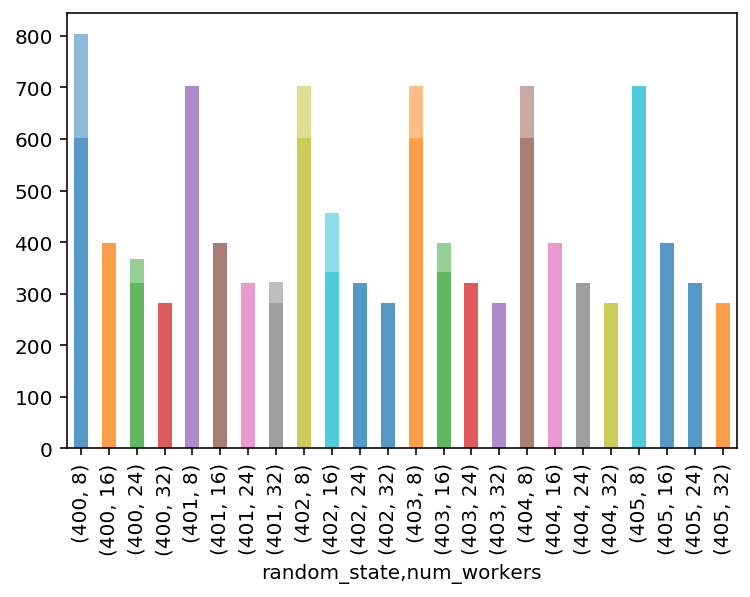

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

for patience in [False, True]:
    show = df[df.patience == patience]
    limits = show.groupby(["random_state", "num_workers"])["elapsed_wall_time (binned)"].max()
#     limits.plot(ax=ax, alpha=1.0, style="o-")
    limits.plot.bar(ax=ax, alpha=0.5, style="o-")

# 400, 402, 403

Text(0.5, 0, 'Time (s)')

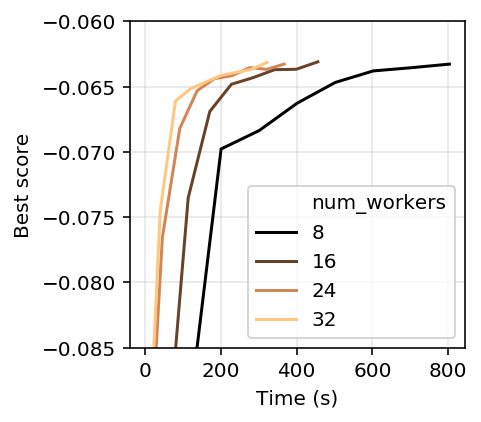

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

def _get_last_score(df):
    d = df.reset_index()
    idx = d.cumulative_partial_fit_calls.idxmax()
    return d.loc[idx]

w = 3
fig, ax = plt.subplots(figsize=(w, w), nrows=1)
df.num_workers = df.num_workers.astype("int")

kwargs = dict(
    x="elapsed_wall_time (binned)",
    y="best_score",
    hue="num_workers",
    ci=None,
    palette="copper",
    estimator="mean",
)
ax = sns.lineplot(
    data=df[df.patience == False],
    ax=ax,
    **kwargs,
)
    
ax.set_ylim(-0.085, -0.06)
ax.grid(alpha=0.3)
ax.set_ylabel("Best score")
ax.set_xlabel("Time (s)")

(0.0, 0.0, 0.0, 1.0)


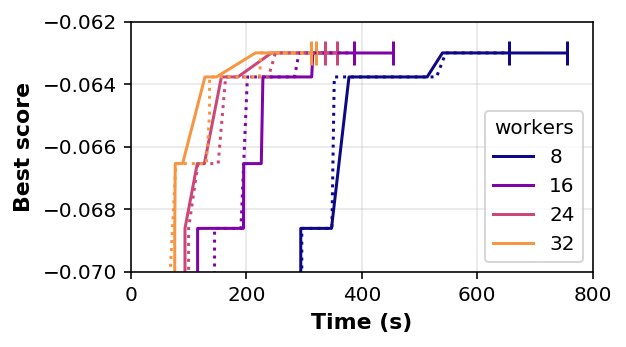

In [22]:
w = 2.3
fig, ax = plt.subplots(figsize=(1.8 * w, w), nrows=1)
from matplotlib import cm
colors = cm.copper(0)
print(colors)

def c(x, cmap="plasma"):
    return getattr(cm, cmap)(x)

n = 4
colors = {8: c(0), 16: c(1 / n), 24: c(2 / n), 32: c(3 / n)}
# styles = {True: "-", False: "-"}
styles = {True: ":", False: "-"}

for patience in [False, True]:
# for patience in [True]:
    for workers in [8, 16, 24, 32]:
        idx = (df.patience == patience) & (df.num_workers == workers)
        idx &= df.random_state == 403
        show = df[idx]
        if patience is False:
#         if patience is True:
            label=f"{workers}"
        else:
            label = None
        ax.plot(
            show.elapsed_wall_time,
            show.best_score,
            styles[patience],
            color=colors[workers],
            label=label,
        )
        end = show.elapsed_wall_time.idxmax()
        end = show.loc[end]
        ax.plot(end.elapsed_wall_time, end.best_score, "|", color=colors[workers], markersize=12, mew=1.5)
    
fontdict = {"weight": "bold", "fontsize": 11}
ax.set_ylabel("Best score", fontdict=fontdict)
ax.set_xlabel("Time (s)", fontdict=fontdict)
ax.legend(loc="best", title="workers")
ax.set_ylim(-0.070, -0.062)
ax.grid(alpha=0.3)
ax.set_xlim(0, 800)
plt.savefig("figs/scaling.pdf", bbox_inches="tight")

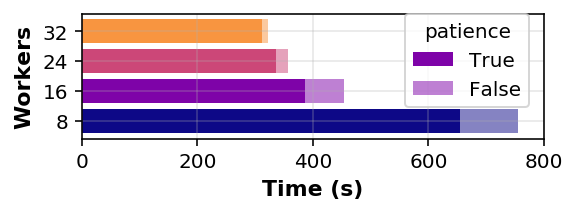

In [14]:
fig, ax = plt.subplots(figsize=(1.8 * w, 0.5 * w), nrows=1)
for patience in [True, False]:
    show = df[(df.random_state == 403) & (df.patience == patience)]
    end = show.pivot_table(
        index="num_workers",
        values="cumulative_partial_fit_calls",
        aggfunc="idxmax",
    )
    end = end.values.flat[:]
    end_times = show.loc[end].groupby("num_workers")["elapsed_wall_time"].max()
    
    for k, (num_worker, end_time) in enumerate(zip(end_times.index, end_times)):
        label = None
        if num_worker == 16:
            label = patience
        alpha = 1 if patience else 0.5
        _ = ax.barh(k, end_time, alpha=alpha, color=colors[num_worker], label=label)
    _ = ax.legend(title="patience", loc=(0.7, 0.25))
    _ = ax.set_yticks([0, 1, 2, 3])
    _ = ax.set_yticklabels([8, 16, 24, 32])
    
ax.set_ylabel("Workers", fontdict=fontdict)
ax.set_xlabel("Time (s)", fontdict=fontdict)
ax.grid(alpha=0.3)
ax.set_xlim(0, 800)

plt.savefig("figs/scaling-patience.pdf", bbox_inches="tight")